# Power Production - a Machine Learning project

The assignment project for Machine Learning and Statistics, GMIT 2020-2021

Lecturer: dr Ian McLoughlin

>Author: **Andrzej Kocielski**  
>Github: [andkoc001](https://github.com/andkoc001/)  
>Email: G00376291@gmit.ie, and.koc001@gmail.com


This Notebook should be read in conjunction with the corresponding README.md file at the project [repository](https://github.com/andkoc001/Machine-Learning-and-Statistics-Project.git) at GitHub.

## Introduction

### Project objectives

The objective of the is to develop a web service to make predictions using Machine Learning (ML) paradigm. 

The goal of the project is to produce a model or models that, based on the provided dataset `powerproduction`, and through applying the appropriate ML techniques, predicts power output generated by wind turbine from wind. The power output predictions should be generated in response to wind speed values to be obtained as HTTP requests.

Further details can be found in the [project brief](https://github.com/andkoc001/Machine-Learning-and-Statistics/blob/main/assessment.pdf).


## Setting the environment

This notebook documents the project development. Please also refer to README.md file in this repository for general information.

### Importing required libraries

For this project the following libraries will be used:

1. Numpy - for numerical operations
2. Pandas - for DataFrame data type
3. Scikit-learn (aka sklearn) - for ML algorithms
4. Matplotlib - for plotting and visualisation
5. Seaborn - for plotting and visualisation

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

# ignor deprecated warnings
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In /home/ak/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ak/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ak/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/ak/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ak/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylel

### Loading the data set from a file

The data set is loaded from the file powerproduction.txt (in the repository). It is stored as a DataFrame and assigned under the name `df_orig`.

In [2]:
df_orig = pd.read_csv(r"powerproduction.txt")

### A glance into the data set

The dataset we are going to work on this project is `powerproduction`. Let us take a sneak peek as to how this dataset looks like. We will attempt to evaluate its size, basic statistical properties, distributions, etc. as well as produce some plots for a better understanding of its properties.  

In [3]:
df_orig

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


In [4]:
df_orig.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


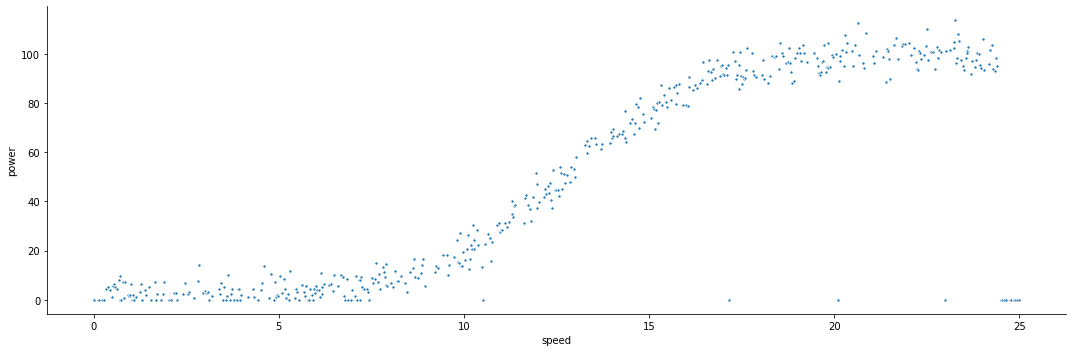

In [5]:
sns.relplot(data=df_orig, x="speed", y="power", s=10, palette="pastel", height=5, aspect=3)

### First thoughts

From the above dataset description and data points plot, the following conclusions can be drawn.

The data set consist of 500 observations (rows). Each observation consists of 2 attributes (columns): wind speed (`speed`) and corresponding power output (`power`). The units of the values are not explicitly given.

The wind speed values varies from 0 to 25 and are shown in descending order. The power output values varies from 0 to 113.556. There are 49 instances where the power output equals zero.

From the plot one can observe three distinct areas with different behaviour of the data points. I will refer to them as zones a), b), c) and d).

a) With wind speed from 0 to about 8, the power output is near to none. 
b) There is a strong almost linear correlation the wind speed and the power output in wind speed range from about 9 to about 17.
c) When wind speed exceeds approximately 17, its effect on the power output is close to constant, and the wind turbines work with a high performance.
d) Above certain wind speed level, approximately 24, the power output abruptly ceased.

Such a behavior can be, perhaps, explained by the fact that at low wind speed (zone a))the wind turbines do not generate any power (or it is not economically justified). On the other hand, in the zone d) where the winds are very strong, the power output is not produced, as if the turbines are shut off for safety reasons.

Occasionally, there is a number of observations where the power output is zero, even though the wind speeds are in zones allowing for producing the power. These are assumed to be data anomaly (e.g. due to incorrect reading). In total, there is 49 observations with power output equal to zero. 

In [6]:
# There is about 10% of the observation with zero power output 
df_orig[df_orig.power == 0].count()

speed    49
power    49
dtype: int64

<AxesSubplot:xlabel='power'>

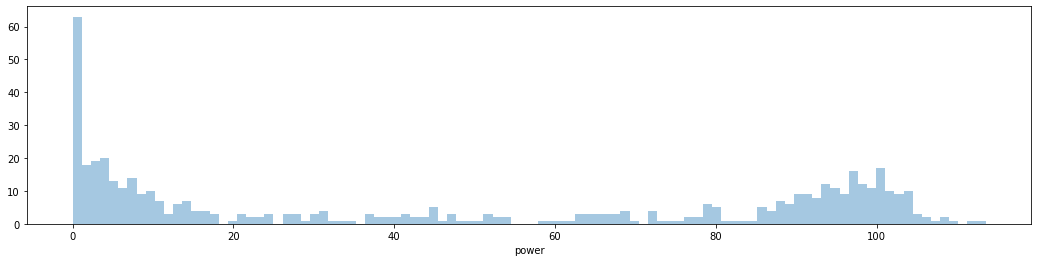

In [7]:
# Histogram of power outputs - frequency of occurance - 'zero' values seem to distort the plot
plt.figure(figsize=(18,4))
sns.distplot(df_orig.power, bins=100, kde=False)

The analysis of the wind speed distribution shows that the wind speed appears to uniformly distribute, with no particular wind speed dominating.

<AxesSubplot:xlabel='speed'>

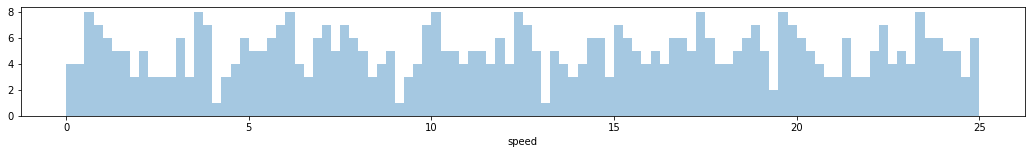

In [8]:
# what wind speeds dominate - it appears to be more or less uniformely distributed
plt.figure(figsize=(18,2))
sns.distplot(df_orig.speed, bins=100, kde=False)

### Clean the dataset

The data set seems to be distorted with the 'zero' power outputs. Let's remove these observations from the dataset.

The cleaned dataset is assigned to `df` object.

In [9]:
# clean the dataset by removing all observations where the power output is zero

df = df_orig[df_orig['power'] !=0]
df

,speed,power
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553
...,...,...
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223


## Linear regression

<AxesSubplot:xlabel='speed', ylabel='power'>

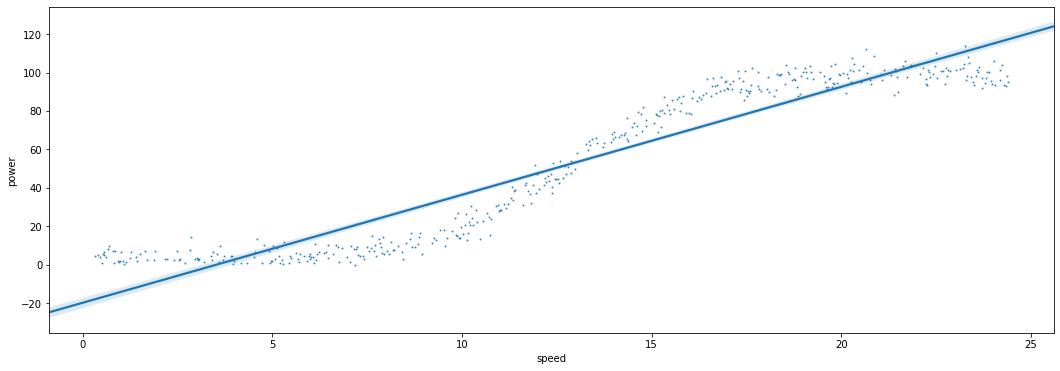

In [10]:
# Linear regression is an underfitting approximation
plt.figure(figsize=(18,6))
sns.regplot(data=df, x="speed", y="power", scatter_kws={'s':1})

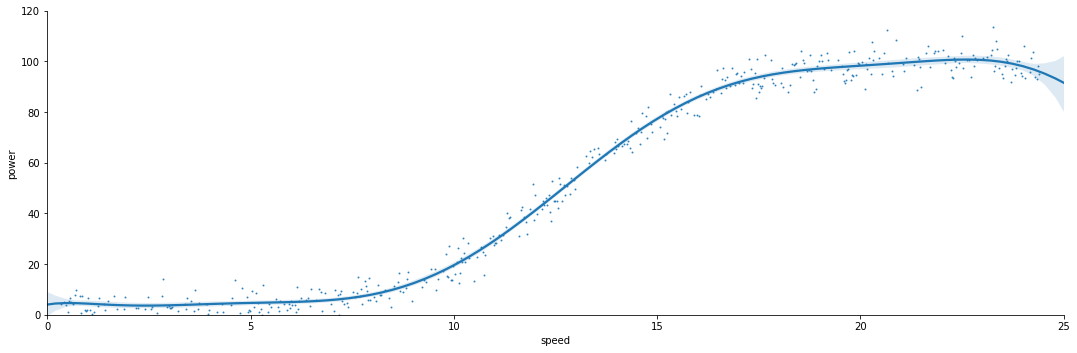

In [11]:
# Polynomial regression for cleaned dataset

a_plot = sns.lmplot(data=df, x="speed", y="power", order=9, height=5, aspect=3, scatter_kws={'s':1})

a_plot.set(xlim=(0, 25))
a_plot.set(ylim=(0, 120))

plt.show()

The above polynomial appears to closely follow the pattern of the data points in the domain (wind speed in range 0-25).

Let's now apply the Numpy's `polyfit()` to get the value of the coefficients that minimise the squared order and plot the polynomial function.

In [12]:
plt.rcParams['figure.figsize'] = [18, 6]

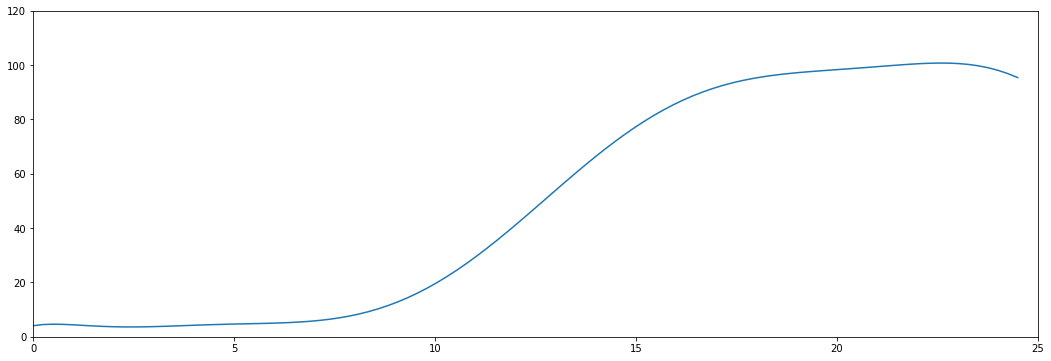

y = 
           9             8             7            6           5
3.076e-08 x - 3.551e-06 x + 0.0001674 x - 0.004137 x + 0.05719 x
          4         3         2
 - 0.441 x + 1.835 x - 3.665 x + 2.535 x + 4.084


In [16]:
coeff = np.polyfit(df['speed'], df['power'], 9)
#coeff

#with warnings.catch_warnings():
#    warnings.simplefilter('ignore', np.RankWarning)    
#    y = np.poly1d(coeff)
    

x = np.linspace(0, 24.5, 101)

yp = np.poly1d(coeff)
xp = plt.plot(x, yp(x))

plt.xlim(0,25)
plt.ylim(0,120)


plt.rcParams['figure.figsize'] = [18, 6]
plt.show()

print("y = ")
print(yp)